# Notebook to reconstruct the images from the autoencoder
### Transfer learning approach to merge two modalities. The weights from the model trained for Optical Coherence Tomography (OCT) reconstruction will be used to initialize the model to segment stereozoom images.

## General Workflow:
- 1. [Package imports](#import-libraries)
- 2. [Load the data](#load-the-images)
- 3. [Without patchify (optional)](#Optional-path-without-patchify)
- 4. [Checking images](#Continue-from-here)
- 5. [Training](#Training)
- 6. [Testing](#Output-the-reconstructed-images-for-quality-check)
- 7. [Save](#Save-the-model)

### Import libraries

In [ ]:
#Import whole libraries
import os
import sys
import cv2
import PIL
import skimage
import sklearn
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# import specific sub-libs or functions/classes
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

### Load the images

In [ ]:
# specify some parameters
SIZE_X = 512 # image hight
SIZE_Y = 1712 # image width

patch_size = (512, 512) # (height, width) of patches
window_step = 128 # patch window step size
n_classes=4 # number of classes (background, epidermis, dermis, subcutaneous)

batch_size = 16 # batch size

In [ ]:
train_images = [] # empty array to store patches

# loop over all the images and split them into smaller patches
for img_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/OCT_sd/", "*.BMP"))):
    img = cv2.imread(img_path, 0)
    p_imgs = patchify(img, patch_size, step=window_step).reshape(-1,*patch_size)
    # print(img.shape)      
    # img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(p_imgs)

In [ ]:
# concatenate all the images into one big array
train_images = np.concatenate(train_images)

In [ ]:
# check the shape of the image array
train_images.shape

(830, 512, 512)

### Optional path without patchify

In [ ]:
maskpath = r"/content/drive/MyDrive/OCT_sd/Mask" #path link to masks
imagepath = r"/content/drive/MyDrive/OCT_sd"     #path link to images

In [ ]:
# find the list of all the images and masks
images = os.listdir(imagepath)
masks = os.listdir(maskpath)

In [ ]:
# Image dimentions
im_height = 512
im_width = 512 * 3

In [ ]:
# Create empty arrays to store images and masks
IMAGES = np.zeros((len(masks), im_height, im_width, 3), dtype=np.float32) #create an empty array for all the examples (instance,hight,width,three channels)

## Load images and masks, resize for training, normalize and convert to floats
for n,image in enumerate(masks): #loop over the mask names and number
    
    print(n,image)

    img =  cv2.imread("{}/{}".format(imagepath,image[:-4]+".BMP"),1) #read the colored image
    img =  cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   #convert to RGB
    img = img[:,87:87+512*3,:]   #resize the image for consistancy (there are some images with diff. dimentions)
    
    IMAGES[n,:,:] = img/255.0   #normalize and convert to floats

0 CC_ns_d0_1.png
1 NT_d12_5.png
2 NT_d12_4.png
3 NT_d12_3.png
4 NT_befwnd_T1_6.png
5 NT_befwnd_T1_4.png
6 NT_befwnd_T1_2.png
7 NT_befwnd_NT1_1.png
8 NT_after_woun_d0_t_6.png
9 CC_wd8_1.png
10 CC_wd8_2.png
11 CC_wd8_3.png
12 CC_wd8_4.png
13 CC_wd12_3.png
14 CC_wd12_4.png
15 CCF_wd0_1.png
16 CCF_wd12_6.png
17 CCF_wd12_5.png
18 NT_befwnd_NT1_2.png
19 NT_befwnd_NT1_3.png
20 NT_befwnd_NT1_4.png
21 CCF_wd12_1.png
22 CCF_wd12_2.png
23 CCF_wd12_3.png
24 CCF_wd0_3.png
25 CCF_wd0_4.png
26 CCF_wd0_5.png
27 CCF_wd0_6.png
28 CCF_wd8_5.png
29 CCF_wd8_4.png
30 CCF_wd8_3.png
31 CCF_wd8_2.png
32 CCF_wd8_1.png
33 CC_wd0_2.png
34 NT_after_woun_d0_t_5.png
35 CCF_wd12_4.png
36 NT_d12_2.png
37 NT_befwnd_T1_3.png
38 CC_wd0_3.png
39 CC_wd0_1.png
40 CC_ns_d0_2.png
41 CC_wd0_5.png
42 CC_wd12_5.png
43 NT_after_woun_d0_t_2.png
44 NT_after_woun_d0_t_3.png
45 CC_wd12_1.png
46 CC_wd12_2.png
47 NT_befwnd_T1_5.png
48 NT_after_woun_d0_t_4.png
49 CCF_wd0_2.png
50 NT_after_woun_d0_nt_1.png
51 NT_after_woun_d4__1.png
52 N

In [ ]:
# split the images in small sizes for training
im1 = IMAGES[:,:,0*512:512*1,:]
im2 = IMAGES[:,:,1*512:512*2,:]
im3 = IMAGES[:,:,2*512:512*3,:]
images_small = np.vstack((im1,im2,im3))

In [ ]:
# check the shape of the image array
images_small.shape

(228, 512, 512, 3)

In [ ]:
# resize dimentions
im_height = 256
im_width = 256

In [ ]:
IMAGES = np.zeros((len(images_small), im_height, im_width, 3), dtype=np.float32) #create an empty array for all the examples (instance,hight,width,three channels)

## Load images and masks, resize for training, normalize and convert to floats
for n,image in enumerate(images_small): #loop over the mask names and number
    img = cv2.resize(image,(im_height,im_width))
    
    IMAGES[n,:,:] = img  #normalize and convert to floats

### Continue from here

In [ ]:
IMAGES = np.expand_dims(train_images,axis=3) #add one dimension for the channel
IMAGES.shape #check the shape of the image array

(830, 512, 512, 1)

(512, 512, 1)

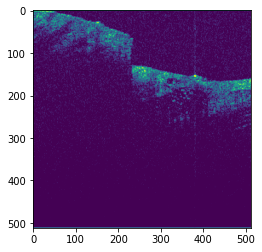

In [ ]:
# plot one image
img = IMAGES[0] 
plt.imshow(img.squeeze())
img.shape #check the shape of the image

### Training

#### Data splits

In [ ]:
# train test split; (you can take the whole dataset for training if you want, I left some images for additional validation)
X_train, X_test = train_test_split(IMAGES,test_size = 0.05)

In [ ]:
# check the shape of the train and test images
X_train.shape, X_test.shape

((788, 512, 512, 1), (42, 512, 512, 1))

#### Setting up the model

In [ ]:
# define the double convolution blocks
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [ ]:
# define the encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p  

In [ ]:
# define the decoder block
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x

In [ ]:
# assemble the encoder path and add the bridge
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    encoded = conv_block(p4, 1024) #Bridge
    
    return encoded

In [ ]:
# assemble the decoder path
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)
    
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

In [ ]:
# assemble the whole autoencoder
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)

In [ ]:
# add model parameters
model=build_autoencoder(img.shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# print(model.summary())

#### Training

In [ ]:
# model training
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
model.fit(X_train, X_train,
        epochs=100,
        batch_size = 3,
        verbose=1,
        callbacks =[callback])

Epoch 1/100
263/263 [==============================] - 188s 651ms/step - loss: 1267.1967 - accuracy: 0.3752
Epoch 2/100
263/263 [==============================] - 169s 642ms/step - loss: 1266.9641 - accuracy: 0.3774
Epoch 3/100
263/263 [==============================] - 169s 642ms/step - loss: 1266.9824 - accuracy: 0.3437
Epoch 4/100
 47/263 [====>.........................] - ETA: 2:18 - loss: 1283.8147 - accuracy: 0.3922

### Output the reconstructed images for quality check

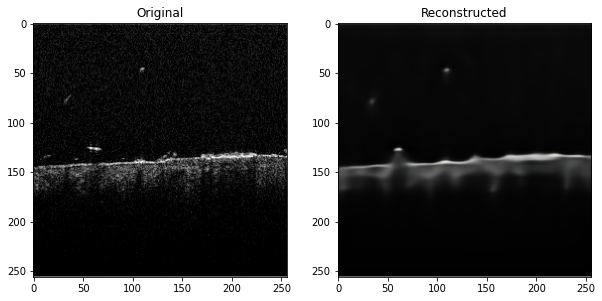

In [ ]:

id = np.random.randint(0,len(X_test))
img = np.expand_dims(X_test[id,:,:,:],axis=0)
pred = model.predict(img).squeeze()
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(img.squeeze())
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Reconstructed')
plt.show()

### Save the model

In [ ]:
model.save(r"C:\Users\Swata\Downloads\Autoencoder_OCT_reconstruct")